heres what the dataframe looks like btw:
   Time (ms)  Centroid_X  Centroid_Y  Feature
0          0  -18.112448   -7.618048       39
1          1  -13.046840   -9.590575       39
2          2   -8.764083  -12.284308       39
3          3   -2.110503  -12.777150       39
4          4    1.029483  -13.182605       39
5          5    5.663209  -10.902855       39
6          6    6.456484   -9.254714       39
7          7    2.735900   -3.856508       39
8          8   -0.484103   -0.866501       39
9          9   -5.195110    3.019698       39
[-18.112448 -13.04684   -8.764083 ... -21.287073 -22.94848  -22.354143]
[ -7.618048   -9.590575  -12.284308  ...  -1.4127754  -2.2394783
  -5.196636 ]
[[-18.112448   -7.618048 ]
 [-13.04684    -9.590575 ]
 [ -8.764083  -12.284308 ]
 ...
 [-16.89624    14.82285  ]
 [-14.328587   12.191551 ]
 [-11.754089    3.9635835]]
10000
epoch number 1,rmse_x=6.232 μm,rmse_y=9.632 μm
epoch number 11,rmse_x=4.322 μm,rmse_y=4.426 μm
epoch number 21,rmse_x=3.522 μm,r

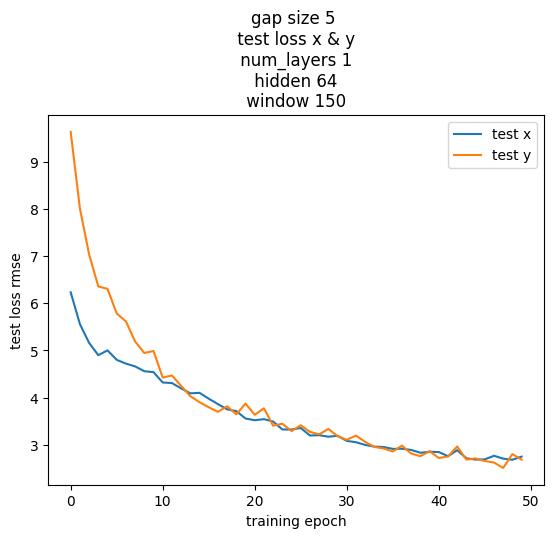

epoch number 1,rmse_x=6.167 μm,rmse_y=9.116 μm
epoch number 11,rmse_x=4.144 μm,rmse_y=4.149 μm
epoch number 21,rmse_x=3.386 μm,rmse_y=3.323 μm
epoch number 31,rmse_x=2.956 μm,rmse_y=2.957 μm
epoch number 41,rmse_x=2.569 μm,rmse_y=2.680 μm


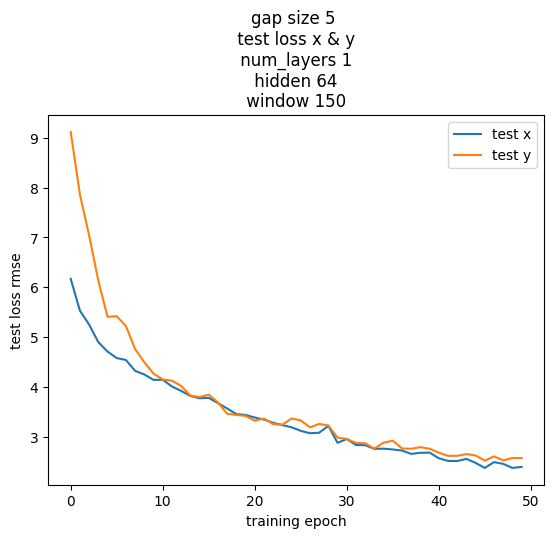

epoch number 1,rmse_x=6.662 μm,rmse_y=10.597 μm
epoch number 11,rmse_x=6.528 μm,rmse_y=10.520 μm


KeyboardInterrupt: 

In [1]:
#libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt

#data loading
df= dataframe = pd.read_feather("combined_centroid_data.feather")
x=df["Centroid_X"].values #.values is a pd attribute #gta take .values attribute to remove all the indexing, just returns array
y=df["Centroid_Y"].values
our_data= np.stack([x,y], axis=1) #stack invents a new axis, we tryna couple the [x_i y_i]
our_data = reduced_size= our_data[:10000] #the paper didnt use all the gazilliopn timesteps, theu used 10**5 i think. but it'll take way to long to run for our purposes, like several days.
print("heres what the dataframe looks like btw:")
print(df[:10])
print(x)
print(y)
print(our_data)
print(len(our_data))

#hyperparams to keep fixed
epochs= 100 #if it doesnt converge, i gotta adjust
batch_siz= 128 #just depending on speed mostly, big minib. faster
lr=.002
hidden=64 #REMEMBER THIS GOTTA B DIVIDISIBLE B nhead WHICH I PUT AS 4 FOR THRANDFORMER
#lets create a class to return input and output data 

class OurJitterDataset():
    def __init__(self,data,window,gap):
        self.data=data
        self.window=window
        self.gap=gap

    def __len__(self): #i use this s.t. i can run .random_split down below
        return len(self.data)-self.window-self.gap #also this makes it so we dont go outside the data!
    
    def __getitem__(self,i):
        input= torch.tensor(self.data[i:i+self.window], dtype=torch.float32) #thisll b 600,2
        output=torch.tensor( self.data[i+self.window+self.gap], dtype=torch.float32) #thisll b 2,. the output prediction
        return input,output
    
# MODELS ########################
#### LSTM
#lets roll out the model
class OurLSTM(nn.Module):
    def __init__(self, hidden, num_layers):
        super().__init__()
        self.lstm=nn.LSTM(2,hidden_size=hidden, num_layers=num_layers,batch_first=True)
        self.out_proj=nn.Linear(hidden,2)

    def forward(self,x):
        output_of_the_lstm,(final_hidden_state,more_irrelevant_stuff)= self.lstm(x)  #
        return self.out_proj(final_hidden_state[-1]) #last layer hidden state, equiv to [0] for us cuz we just have 1 layer
#### LSTM+CNN
class OurCNNLSTM(nn.Module):
    def __init__(self, hidden, num_layers):
        super().__init__()
        self.conv= nn.Conv1d(2,32,kernel_size=5,padding=2)  
        self.lstm= nn.LSTM(32,hidden_size=hidden,num_layers=num_layers,batch_first=True)
        self.out_proj= nn.Linear(hidden, 2)
    
    def forward(self, x):
        x= x.permute(0,2,1)        
        x= torch.relu(self.conv(x))  
        x= x.permute(0,2,1)      
        output_of_the_lstm,(final_hidden_state,more_irrelevant_stuff)= self.lstm(x)
        return self.out_proj(final_hidden_state[-1])
#### TRANSF
class OurTransformer(nn.Module):
    def __init__(self, hidden, num_layers):
        super().__init__()
        self.input_proj=nn.Linear(2,hidden)
        encoder_layer=nn.TransformerEncoderLayer(d_model=hidden,nhead=4,batch_first=True)
        self.transformer= nn.TransformerEncoder(encoder_layer,num_layers=num_layers)
        self.out_proj= nn.Linear(hidden,2)
    
    def forward(self,x):
        x= self.input_proj(x)         
        x= self.transformer(x)         
        return self.out_proj(x[:, -1])   #last timestep
                    


#the 3 hyperparams to vary
for gap in [5,10,20]:
    for window in [150,300,600]:

        #load up the data. we can put it here bc it only depends on gap and window, not num layers in the model
        our_dataset = OurJitterDataset(our_data,window,gap)
        train_size=int(.8*len(our_dataset))
            
        train_data,test_data= torch.utils.data.random_split(our_dataset,[train_size,len(our_dataset)-train_size])
        train_loader= DataLoader(train_data,batch_size=batch_siz,shuffle=True)
        test_loader= DataLoader(test_data,batch_size=batch_siz,shuffle=True)

        for num_layers in [1,2,3]:
            for model_class in [OurLSTM, OurCNNLSTM , OurTransformer]:

                our_model = model_class(hidden,num_layers) #instantiating and initializing the model based on the model class which we loop over
                # -------------------------------------------
                ###########################################here!!!!!!!!!!
                optimizer=torch.optim.Adam(our_model.parameters(),lr=lr)
                loss_fn = nn.MSELoss()
                rmse_list_x=[]
                rmse_list_y=[]
                loss_list=[]

                for epoch in range(epochs):
                    our_model.train()
                    for inp,target in train_loader:
                        pred=our_model(inp)
                        l=loss_fn(pred, target)
                        loss_list.append(l.item()) #.item() gets the value... bc remember, l will have gradient attched to it
                        optimizer.zero_grad()
                        l.backward()
                        optimizer.step()
                    
                    our_model.eval()
                    errors=[]
                    with torch.no_grad():
                        for inp,target in test_loader:
                            pred= our_model(inp)
                            errors.append((pred-target).numpy())
                    errors=np.concatenate(errors)
                    rmse_x= np.sqrt((errors[:,0]**2).mean())
                    rmse_y= np.sqrt((errors[:,1]**2).mean())
                    rmse_list_x.append(rmse_x)
                    rmse_list_y.append(rmse_y)
                    if epoch%10==0:
                        print(f"epoch number {epoch+1},rmse_x={rmse_x:.3f} μm,rmse_y={rmse_y:.3f} μm")

                fig=plt.figure()
                ax=fig.add_subplot()
                ax.plot(rmse_list_x,label="test x")
                ax.plot(rmse_list_y,label="test y")
                ax.legend()
                ax.set_xlabel("training epoch")
                ax.set_ylabel("test loss rmse")
                ax.set_title(f"gap size {gap} \n test loss x & y \n num_layers {num_layers} \n hidden {hidden} \n window {window} ")
                
                #all the plots!!!! all plots are gonna get saved into the directory, so the folder we store this file in 
                plt.savefig(f"plot_{model_class.__name__}_gap{gap}_window{window}_num_layers{num_layers}")                        #turns out u gotta save before showing lest u get an empty plot. also use the name dunders to avoid those classic ugly brackets u get othewise
                #lets save the trained model. lemme just give it unmistakeable names:
                torch.save(our_model.state_dict(), f"params_{model_class.__name__}_gap{gap}_window{window}_num_layers{num_layers}")

                np.save(f"rmse_x_{model_class.__name__}_gap{gap}_window{window}_num_layers{num_layers}", rmse_list_x)
                np.save(f"rmse_y_{model_class.__name__}_gap{gap}_window{window}_num_layers{num_layers}", rmse_list_y)
                np.save(f"loss_list_{model_class.__name__}_gap{gap}_window{window}_num_layers{num_layers}", loss_list)

                plt.show()

# below is the same code, except in the way we originally wrote it, which is ipynb format. code above however runs grid search loop, hence all in one cell (the in loop above also we have added a few things things like torch.save(), plt.save() etc.) also just load w np.load etc the saved stuff from above so we can put it in our paper

### experimenting with various architectures beyond MLP :-)
##############################################################
#### 1. LSTM
#### 2. CNN + LSTM
#### 3. Transformer
##############################################################
### for each of these, i'll vary: 
#### 1. num_layers
#### 2. hidden size (aka dimensionality)
#### 3. Input window length (150,300,600)... it could be that too many time-samples cause overfitting
##############################################################
#####   technically, we could do a grid search and try like 3 combos of each hyperparam, i.e. 3x3x3=27 runs for each architecture type
#####   however, i'll just run "fix and vary". it's unlikely that there are interactions here between the hyperparams


In [ ]:
#libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt

#data loading
df= dataframe = pd.read_feather("combined_centroid_data.feather")
x=df["Centroid_X"].values #.values is a pd attribute #gta take .values attribute to remove all the indexing, just returns array
y=df["Centroid_Y"].values
our_data= np.stack([x,y], axis=1) #stack invents a new axis, we tryna couple the [x_i y_i]
our_data = reduced_size= our_data[:10000] #the paper didnt use all the gazilliopn timesteps, theu used 10**5 i think

In [20]:
print("heres what the dataframe looks like btw:")
print(df[:10])
print(x)
print(y)
print(our_data)
print(len(our_data))

heres what the dataframe looks like btw:
   Time (ms)  Centroid_X  Centroid_Y  Feature
0          0  -18.112448   -7.618048       39
1          1  -13.046840   -9.590575       39
2          2   -8.764083  -12.284308       39
3          3   -2.110503  -12.777150       39
4          4    1.029483  -13.182605       39
5          5    5.663209  -10.902855       39
6          6    6.456484   -9.254714       39
7          7    2.735900   -3.856508       39
8          8   -0.484103   -0.866501       39
9          9   -5.195110    3.019698       39
[-18.112448 -13.04684   -8.764083 ... -21.287073 -22.94848  -22.354143]
[ -7.618048   -9.590575  -12.284308  ...  -1.4127754  -2.2394783
  -5.196636 ]
[[-18.112448    -7.618048  ]
 [-13.04684     -9.590575  ]
 [ -8.764083   -12.284308  ]
 ...
 [ -0.63192445   1.02285   ]
 [  3.8037598    1.02285   ]
 [  8.485918     0.28353426]]
1000


In [21]:
#hyperparams to keep fixed
epochs= 100 #if it doesnt converge, i gotta adjust
batch_siz= 128 #just depending on speed mostly, big minib. faster
gap=20
lr=.002

#the 3 hyperparams to vary
num_layers=3
hidden=64 #REMEMBER THIS GOTTA B DIVIDISIBLE B nhead WHICH I PUT AS 4 FOR THRANDFORMER
window=600

In [22]:
#lets create a class to return input and output data 

class OurJitterDataset():
    def __init__(self,data,window,gap):
        self.data=data
        self.window=window
        self.gap=gap

    def __len__(self): #i use this s.t. i can run .random_split down below
        return len(self.data)-self.window-self.gap #also this makes it so we dont go outside the data!
    
    def __getitem__(self,i):
        input= torch.tensor(self.data[i:i+self.window], dtype=torch.float32) #thisll b 600,2
        output=torch.tensor( self.data[i+self.window+self.gap], dtype=torch.float32) #thisll b 2,. the output prediction
        return input,output

In [23]:
#load up the data
our_dataset = OurJitterDataset(our_data,window,gap)
train_size=int(.8*len(our_dataset))
    
train_data,test_data= torch.utils.data.random_split(our_dataset,[train_size,len(our_dataset)-train_size])
train_loader= DataLoader(train_data,batch_size=batch_siz,shuffle=True)
test_loader= DataLoader(test_data,batch_size=batch_siz,shuffle=True)


# MODELS ########################

#### LSTM

In [24]:
#lets roll out the model
class OurLSTM(nn.Module):
    def __init__(self, hidden, num_layers):
        super().__init__()
        self.lstm=nn.LSTM(2,hidden_size=hidden, num_layers=num_layers,batch_first=True)
        self.out_proj=nn.Linear(hidden,2)

    def forward(self,x):
        output_of_the_lstm,(final_hidden_state,more_irrelevant_stuff)= self.lstm(x)  #
        return self.out_proj(final_hidden_state[-1]) #last layer hidden state, equiv to [0] for us cuz we just have 1 layer

#### LSTM+CNN

In [25]:
class OurCNNLSTM(nn.Module):
    def __init__(self, hidden, num_layers):
        super().__init__()
        self.conv= nn.Conv1d(2,32,kernel_size=5,padding=2)  
        self.lstm= nn.LSTM(32,hidden_size=hidden,num_layers=num_layers,batch_first=True)
        self.out_proj= nn.Linear(hidden, 2)
    
    def forward(self, x):
        x= x.permute(0,2,1)        
        x= torch.relu(self.conv(x))  
        x= x.permute(0,2,1)      
        output_of_the_lstm,(final_hidden_state,more_irrelevant_stuff)= self.lstm(x)
        return self.out_proj(final_hidden_state[-1])

#### TRANSF

In [26]:
class OurTransformer(nn.Module):
    def __init__(self, hidden, num_layers):
        super().__init__()
        self.input_proj=nn.Linear(2,hidden)
        encoder_layer=nn.TransformerEncoderLayer(d_model=hidden,nhead=4,batch_first=True)
        self.transformer= nn.TransformerEncoder(encoder_layer,num_layers=num_layers)
        self.out_proj= nn.Linear(hidden,2)
    
    def forward(self,x):
        x= self.input_proj(x)         
        x= self.transformer(x)         
        return self.out_proj(x[:, -1])   #last timestep

# -------------------------------------------

In [27]:
our_model=OurTransformer(hidden,num_layers)
optimizer=torch.optim.Adam(our_model.parameters(),lr=lr)
loss = nn.MSELoss()

In [28]:
rmse_list_x=[]
rmse_list_y=[]

for epoch in range(epochs):
    our_model.train()
    for inp,target in train_loader:
        pred=our_model(inp)
        l=loss(pred, target)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    
    our_model.eval()
    errors=[]
    with torch.no_grad():
        for inp,target in test_loader:
            pred= our_model(inp)
            errors.append((pred-target).numpy())
    errors=np.concatenate(errors)
    rmse_x= np.sqrt((errors[:,0]**2).mean())
    rmse_y= np.sqrt((errors[:,1]**2).mean())
    rmse_list_x.append(rmse_x)
    rmse_list_y.append(rmse_y)
    print(f"epoch number {epoch+1},rmse_x={rmse_x:.3f} μm,rmse_y={rmse_y:.3f} μm")



fig=plt.figure()
ax=fig.add_subplot()
ax.plot(rmse_list_x,label="test x")
ax.plot(rmse_list_y,label="test y")
ax.legend()
ax.set_xlabel("training epoch")
ax.set_ylabel("test loss rmse")
ax.set_title(f"test loss x & y \n num_layers {num_layers} \n hidden {hidden} \n window {window} ")

epoch number 1,rmse_x=8.185 μm,rmse_y=9.739 μm


KeyboardInterrupt: 